# Semantic Segamantaion with UNET

Tung Ng.

In [1]:
import tensorflow as tf

Actiavte TPU to accelerate deep learning model (keras)

In [2]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [3]:
import numpy as np
import pandas as pd
import os
import rasterio
import rasterio.features
import rasterio.warp
from rasterio.plot import show
from rasterio.mask import mask
import shapely
from fiona.crs import from_epsg
import geopandas as gpd
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
%matplotlib inline

scale array in range (0, 1) to reduce gradient exploding when train model

In [5]:
def scale(array):
    arr_min = array.min(axis=(0, 1))
    arr_max = array.max(axis=(0, 1))
    return (array - arr_min) / (arr_max - arr_min)

# 1. Visualize Dataset

In [6]:
dataset = rasterio.open('../input/farmboundaries/train/Germany.tif')
polygons = gpd.read_file('../input/farmboundaries/train/field_ger.shp')

Check dataset's coordinates

In [7]:
print("Dataset's crs ", dataset.crs)
print("Polygons's crs ", polygons.crs)

Dataset's crs  EPSG:3785
Polygons's crs  {'init': 'epsg:4326'}


dataset's coordinates is different from shape's. So we need change crs of shape (Because dataset is read-only)

In [8]:
polygons_mercator = polygons.to_crs({'init': 'epsg:3785'}) 
print("polygons_mercator's crs ", polygons_mercator.crs)

polygons_mercator's crs  {'init': 'epsg:3785'}


/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [9]:
shapes = []
geo = polygons_mercator.values[:, 1]
for i in range(len(polygons_mercator)):
    shapes.append(geo[i])

Create mask from dataset and shape

In [10]:
out = rasterio.mask.raster_geometry_mask(dataset, shapes)
masks = out[0].astype(np.int8)

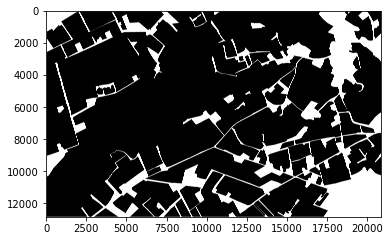

In [11]:
plt.imshow(masks, cmap='gray')

In [13]:
rgb = dataset.read()

In [14]:
print('shape of rgb: ', rgb.shape)
print('shape of masks: ', masks.shape)

shape of rgb:  (3, 12833, 20833)
shape of masks:  (12833, 20833)


I had only used a part of dataset

In [15]:
rgb1 = rgb[:, 2560:12800, 13600:20000]
masks1 = masks[2560:12800,  13600:20000]
rgb2 = rgb[:, 0:2560, 0:5120]
masks2 = masks[0:2560,  0:5120]

Text(0.5, 1.0, 'Mask 2')

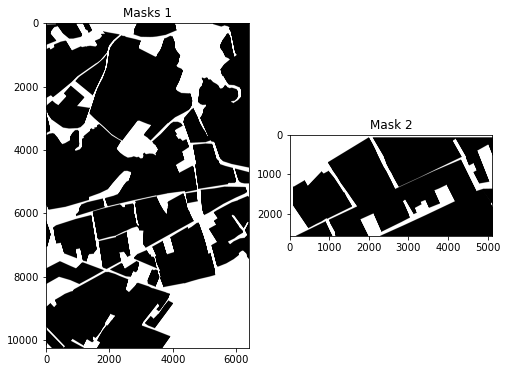

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(masks1, cmap = 'gray')
ax[0].set_title('Masks 1')
ax[1].imshow(masks2, cmap = 'gray')
ax[1].set_title('Mask 2')

# 2. Data pre-processing

In [18]:
print('shape of rgb1: ', rgb1.shape)
print('shape of masks1: ', masks1.shape)
print('shape of rgb2: ', rgb2.shape)
print('shape of masks2: ', masks2.shape)

shape of rgb1:  (3, 10240, 6400)
shape of masks1:  (10240, 6400)
shape of rgb2:  (3, 2560, 5120)
shape of masks2:  (2560, 5120)


In [19]:
rgb1 = np.transpose(rgb1, (1, 2, 0))
rgb1 = scale(rgb1)
rgb2 = np.transpose(rgb2, (1, 2, 0))
rgb2 = scale(rgb2)

In [20]:
rgb1 = resize(rgb1, (10240, 6400, 1), mode = 'constant', preserve_range = True)
rgb2 = resize(rgb2, (2560, 5120, 1), mode = 'constant', preserve_range = True)

In [21]:
masks1 = resize(masks1, (10240, 6400, 1), mode = 'constant', preserve_range = True)
masks2 = resize(masks2, (2560, 5120, 1), mode = 'constant', preserve_range = True)

From cropped photos and their corresponding masks, create dataset for model. 

In [22]:
X = []
y = []
for i in range(0, 10240, 128):
    for j in range(0, 6400, 128):
        X.append(rgb1[i:i+128, j:j+128, :])
        y.append(masks1[i:i+128, j:j+128, :])
for i in range(0, 2560, 128):
    for j in range(0, 5120, 128):
        X.append(rgb2[i:i+128, j:j+128, :])
        y.append(masks2[i:i+128, j:j+128, :])

In [23]:
X = np.asarray(X)
y = np.asarray(y)

split dataset

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=42)

In [25]:
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_valid: ', X_valid.shape)
print('y_valid: ', y_valid.shape)

X_train:  (4080, 128, 128, 1)
y_train:  (4080, 128, 128, 1)
X_valid:  (720, 128, 128, 1)
y_valid:  (720, 128, 128, 1)


Plot a random sample (both satellite image and its mask)

In [26]:
def plot_sample(X, y, id):
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(X[id, ..., 0])
    ax[0].set_title('Satellite')
    ax[1].imshow(y[id,..., 0], cmap = 'gray')
    ax[1].set_title('Mask')

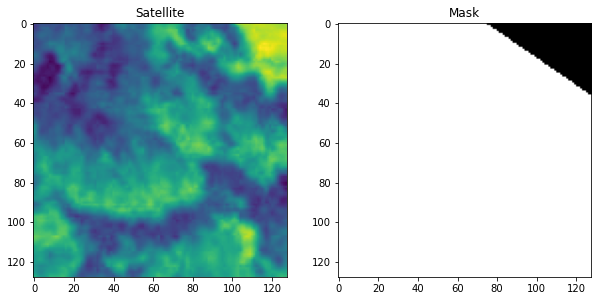

In [27]:
plot_sample(X, y, 1997)

# 3. UNET Model

In [28]:
import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

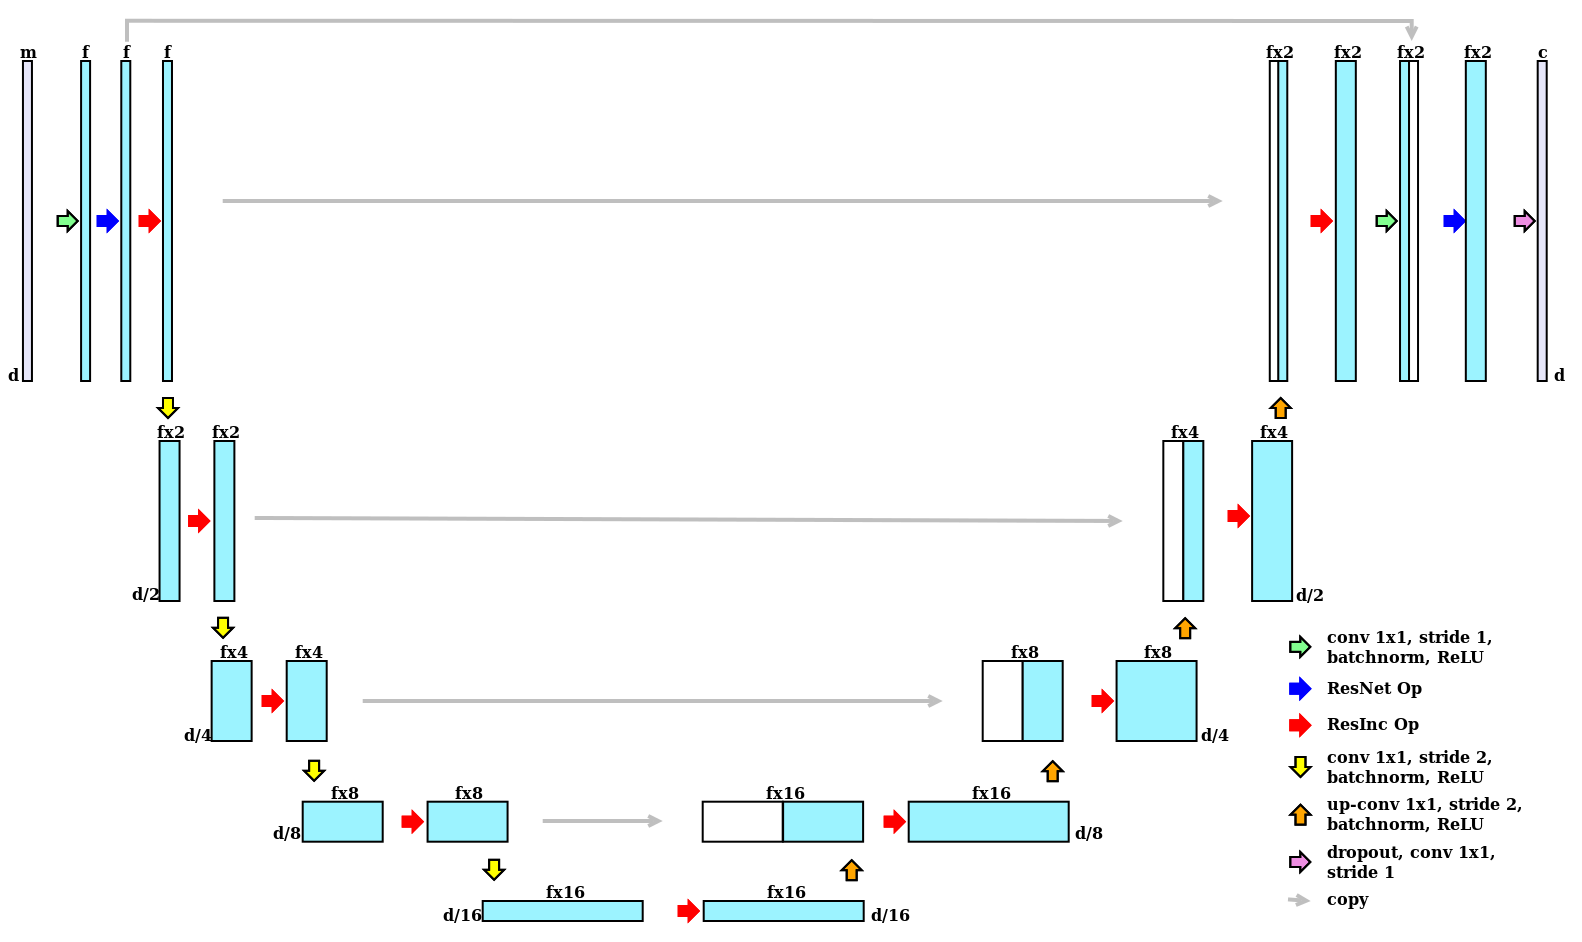

The main idea is to supplement a usual contracting network by successive layers, where pooling operations are replaced by upsampling operators. Hence these layers increase the resolution of the output. What's more, a successive convolutional layer can then learn to assemble a precise output based on this information.

In [29]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    # 1st layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # 2nd layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [30]:
def get_unet(input_img, n_filters = 16, dropout = 0.05, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [31]:
im_width = 128
im_height = 128

In [32]:
input_img = Input((im_height, im_width, 1), name='img')
with tpu_strategy.scope():
    model = get_unet(input_img, n_filters=16, dropout=0.1, batchnorm=True)
    model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

Use callbacks to optimize training process

In [34]:
earlyStopping = EarlyStopping(patience=7, verbose=1)
mcp_save = ModelCheckpoint('farm_model.h5', verbose=1, save_best_only=True, save_weights_only=True)
reduce_lr_loss = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=0)
callbacks = [earlyStopping, mcp_save, reduce_lr_loss]

In [35]:
results = model.fit(X_train, y_train, batch_size=32, epochs=35, callbacks = callbacks, validation_data=(X_valid, y_valid))

Epoch 1/35
128/128 [==============================] - ETA: 0s - loss: 0.4713 - accuracy: 0.7775
Epoch 00001: val_loss improved from inf to 1.37184, saving model to farm_model.h5
128/128 [==============================] - 16s 126ms/step - loss: 0.4713 - accuracy: 0.7775 - val_loss: 1.3718 - val_accuracy: 0.7075 - lr: 0.0010
Epoch 2/35
127/128 [============================>.] - ETA: 0s - loss: 0.4053 - accuracy: 0.8167
Epoch 00002: val_loss did not improve from 1.37184
128/128 [==============================] - 4s 30ms/step - loss: 0.4053 - accuracy: 0.8167 - val_loss: 3.1472 - val_accuracy: 0.7075 - lr: 0.0010
Epoch 3/35
127/128 [============================>.] - ETA: 0s - loss: 0.3705 - accuracy: 0.8404
Epoch 00003: val_loss improved from 1.37184 to 0.88506, saving model to farm_model.h5
128/128 [==============================] - 4s 33ms/step - loss: 0.3705 - accuracy: 0.8403 - val_loss: 0.8851 - val_accuracy: 0.7496 - lr: 0.0010
Epoch 4/35
127/128 [============================>.] - ET

Epoch 28/35
128/128 [==============================] - ETA: 0s - loss: 0.2124 - accuracy: 0.9179
Epoch 00028: val_loss improved from 0.25001 to 0.24526, saving model to farm_model.h5
128/128 [==============================] - 4s 33ms/step - loss: 0.2124 - accuracy: 0.9179 - val_loss: 0.2453 - val_accuracy: 0.9035 - lr: 1.0000e-04
Epoch 29/35
127/128 [============================>.] - ETA: 0s - loss: 0.2131 - accuracy: 0.9175
Epoch 00029: val_loss did not improve from 0.24526
128/128 [==============================] - 4s 31ms/step - loss: 0.2128 - accuracy: 0.9176 - val_loss: 0.2551 - val_accuracy: 0.8974 - lr: 1.0000e-04
Epoch 30/35
127/128 [============================>.] - ETA: 0s - loss: 0.2147 - accuracy: 0.9171
Epoch 00030: val_loss improved from 0.24526 to 0.24053, saving model to farm_model.h5
128/128 [==============================] - 4s 33ms/step - loss: 0.2143 - accuracy: 0.9173 - val_loss: 0.2405 - val_accuracy: 0.9056 - lr: 1.0000e-04
Epoch 31/35
127/128 [==================

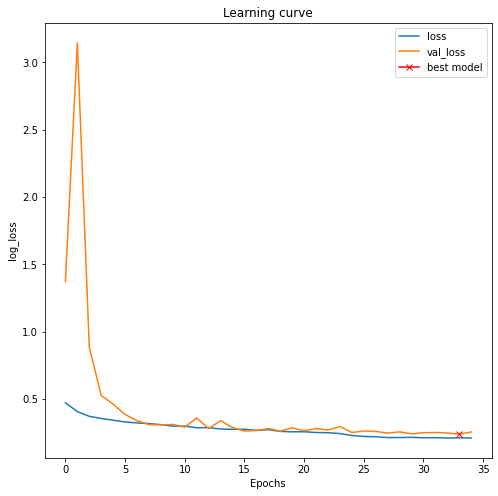

In [36]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [37]:
model.evaluate(X_valid, y_valid, verbose=1)

23/23 [==============================] - 0s 12ms/step - loss: 0.2539 - accuracy: 0.9003


[0.25394001603126526, 0.9003028273582458]

In [38]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

23/23 [==============================] - 0s 20ms/step


In [39]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [40]:
import random

In [41]:
def plot_prediction(X, y, preds, binary_preds, id=None):
    if id is None:
        id = random.randint(0, len(X))

    has_mask = y[id].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[id, ..., 0])
    if has_mask:
        ax[0].contour(y[id].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Satellite')

    ax[1].imshow(y[id].squeeze(), cmap = 'gray')
    ax[1].set_title('Farm')

    ax[2].imshow(preds[id].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[id].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Farm Predicted')
    
    ax[3].imshow(binary_preds[id].squeeze(), vmin=0, vmax=1, cmap = 'gray')
    if has_mask:
        ax[3].contour(y[id].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Farm Predicted binary');

# 4. Predictions 

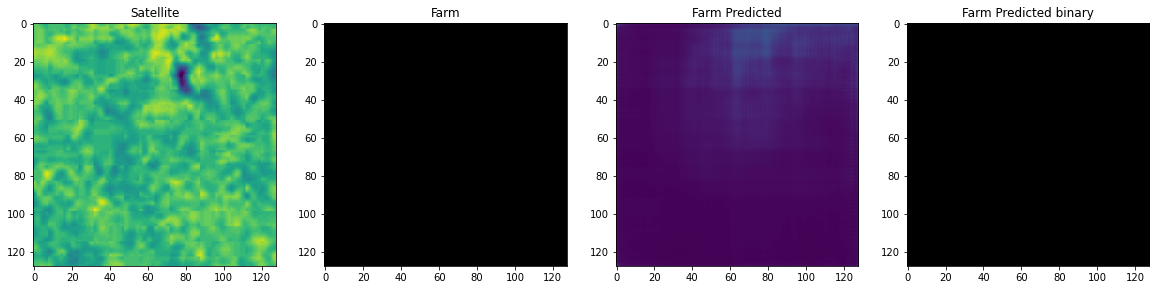

In [42]:
plot_prediction(X_train, y_train, preds_train, preds_train_t)

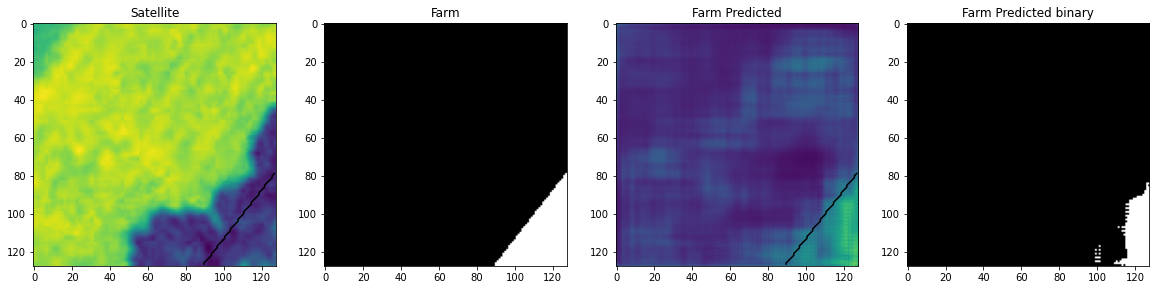

In [44]:
plot_prediction(X_train, y_train, preds_train, preds_train_t)

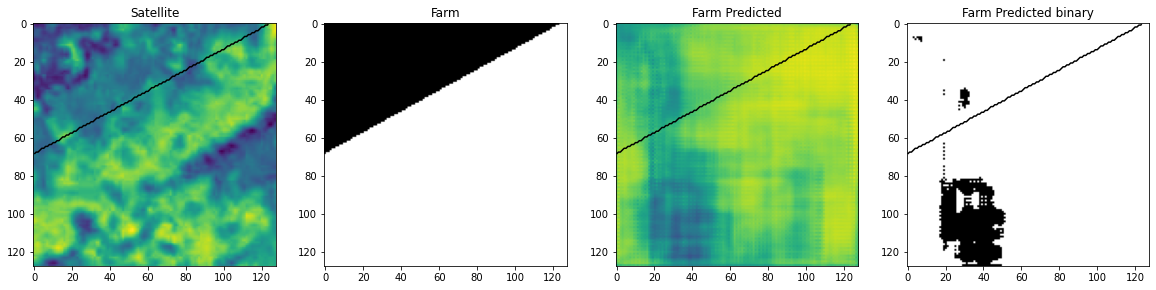

In [46]:
plot_prediction(X_train, y_train, preds_train, preds_train_t)